In [1]:
# Liberary
import numpy as np
from scipy.interpolate import CubicSpline
import datetime
import threading
import multiprocessing as mp
from matplotlib import pyplot as plt
from time import time
from scipy.stats import norm
%matplotlib inline
plt.style.use('bmh')

In [2]:
import sympy
z = sympy.symbols('z')
dt = sympy.symbols('dt')

K0 = 1e-3
K1 = 6e-3  # m / s
Aalpha = 0.5
c = 10
w = 0

sym_Diffu = K0 + K1 * z * sympy.exp(-Aalpha * z)
sym_dKdz = sympy.diff(sym_Diffu, z, 1)
sym_Beta = sympy.sqrt(2 * sym_Diffu)
sym_dBdz = sympy.diff(sym_Beta, z, 1)
sym_ddBdzz = sympy.diff(sym_Beta, z, 2)
sym_Alpha = w + sym_dKdz
sym_dAdz = sympy.diff(sym_Alpha, z, 1)
sym_ddAdzz = sympy.diff(sym_Alpha, z, 2)
sym_dABdz = sympy.diff(sym_Alpha * sym_Beta, z, 1)
sym_F = -(z + sym_Alpha*dt)/sym_Beta
sym_dFdz = sympy.diff(sym_F, z, 1)
sym_F_const = -(z)/sympy.sqrt(2*3e-3)
sym_dFdz_const = sympy.diff(sym_F_const, z, 1)

Diffu  =  sympy.utilities.lambdify(z,          sym_Diffu,np)
dKdz   =  sympy.utilities.lambdify(z,          sym_dKdz,np)
Beta   =  sympy.utilities.lambdify(z,          sym_Beta,np)
dBdz   =  sympy.utilities.lambdify(z,          sym_dBdz,np)
ddBdzz=  sympy.utilities.lambdify(z,          sym_ddBdzz,np)
Alpha =  sympy.utilities.lambdify(z,      sym_Alpha,np)
dAdz  =  sympy.utilities.lambdify(z,      sym_dAdz,np)
ddAdzz=  sympy.utilities.lambdify(z,      sym_ddAdzz,np)
dABdz =  sympy.utilities.lambdify(z, sym_Alpha*sym_Beta,np)
F = sympy.utilities.lambdify([z, dt], sym_F,np)
dFdz = sympy.utilities.lambdify([z, dt], sym_dFdz,np)
F_const = sympy.utilities.lambdify([z, dt], sym_F_const,np)
dFdz_const = sympy.utilities.lambdify([z, dt], sym_dFdz_const,np)
del z, dt

#######
#Euler#
#######
def step_e(z,H,dt,N_sample):

    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    a=dKdz(z)
    b=np.sqrt(2*Diffu(z))
    temp=z+a*dt+b*dW
    return temp

def step_e_const(z,H,dt,N_sample):
    
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    K0=3e-3
    b=np.sqrt(2*K0)
    
    temp=z+b*dW
    return temp

In [3]:
# Parallel functions

def oneStep(Z ,scheme, H, dt):
    
    Z_Origin = Z.copy()
    Z = scheme(Z, H, dt, Z.size)
    
    maskCross = ((H < Z) | (0 > Z)) 
    Crossing = Z_Origin[maskCross]
    
    Z = np.where(Z < 0, -Z, Z)
    Z = np.where(Z > H, 2*H - Z, Z)
    
    Landing = Z[maskCross]
    
    return Z, Crossing, Landing

def parallel(Tmax, dt, H, Testdepth, Np, Nbins, quene, queneCross, queneLand,
             scheme):

    np.random.seed()
    Ntime = int(Tmax / dt)

    hist_ = np.zeros((Nbins - 1, ), 'uint64')
    hist_Cross = np.zeros((Nbins - 1, ), 'uint64')
    hist_Land = np.zeros((Nbins - 1, ), 'uint64')

    #z = np.linspace(0, H, int(Np))
    z = np.random.uniform(0, H, int(Np))

    temp0, _ = np.histogram(z, bins=np.linspace(0, Testdepth, Nbins))
    hist_ = hist_ + temp0
    
    for i in range(Ntime):

        z, Cross, Land = oneStep(z, scheme, H, dt)

        #Adding the histogram
        ###
        temp0, _ = np.histogram(z, bins=np.linspace(0, Testdepth, Nbins))
        hist_ = hist_ + temp0

        temp2, _ = np.histogram(Cross, bins=np.linspace(0, Testdepth, Nbins))
        hist_Cross = hist_Cross + temp2

        temp3, _ = np.histogram(Land, bins=np.linspace(0, Testdepth, Nbins))
        hist_Land = hist_Land + temp3
        
        try:
            if (i % int(Ntime / 100) == 0):
                print("\r %6.2f" % (i * 100 / Ntime + 1),
                      "%",
                      end="\r",
                      flush=True)
        except ZeroDivisionError as err:
            None
            
    quene.put(hist_)
    queneCross.put(hist_Cross)
    queneLand.put(hist_Land)

    return None

def RunSimulation(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, scheme):
    print("Total number of process: ", NumberOfThread)
    SubNp = np.full((NumberOfThread, ), int(Np / NumberOfThread))
    SubNp[-1] = SubNp[-1] + (Np % NumberOfThread)
    
    Ntime = int(Tmax / dt)  #Number of time interval

    if (__name__ == '__main__'):

        threads = []
        quene = mp.Queue()
        queneCross = mp.Queue()
        queneLand = mp.Queue()

        for i in range(NumberOfThread):
            thread = mp.Process(target=parallel,
                                args=(Tmax, dt, H, Testdepth, SubNp[i], Nbins,
                                      quene, queneCross, queneLand, scheme))

            threads.append(thread)
            thread.start()  #starting calculation.

        for thread in threads:
            thread.join()  #waiting these processes finish.

    hist_ = np.zeros((Nbins - 1, ), 'float64')
    hist_Cross = np.zeros((Nbins - 1, ), 'float64')
    hist_Land = np.zeros((Nbins - 1, ), 'float64')

    for i in range(NumberOfThread):
        hist_ += quene.get()
        hist_Cross += queneCross.get()
        hist_Land += queneLand.get()
        
    bins = np.linspace(0, Testdepth, Nbins)
    dz = bins[1] - bins[0]
    hist_ = (hist_*H) / (Np * dz * (Ntime+1))
    
    midpoints = bins[:-1] + (bins[1]-bins[0]) / 2
    hist_Cross = hist_Cross / (np.sum(hist_Cross)*(midpoints[1]-midpoints[0]))
    hist_Land = hist_Land / (np.sum(hist_Land)*(midpoints[1]-midpoints[0]))

    return hist_, hist_Cross, hist_Land

## Figure 3.11

In [4]:
Np = 240000
Nbins = 200
dt = 10
Tmax = dt * 3 * 3600
H = 10
Testdepth = 0.7
NumberOfThread = 4

startTime = time()
E1, E1_Cross, E1_Land = RunSimulation(NumberOfThread, Tmax, dt, H, Testdepth,
                                      Np, Nbins, step_e)
endTime = time()
print("Time elapsed: ", endTime - startTime)

startTime = time()
E1_Const, E1_Const_Cross, E1_Const_Land = RunSimulation(
    NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, step_e_const)
endTime = time()
print("Time elapsed: ", endTime - startTime)

Total number of process:  4
Time elapsed:  156.12714910507202
Total number of process:  4
Time elapsed:  107.4533064365387


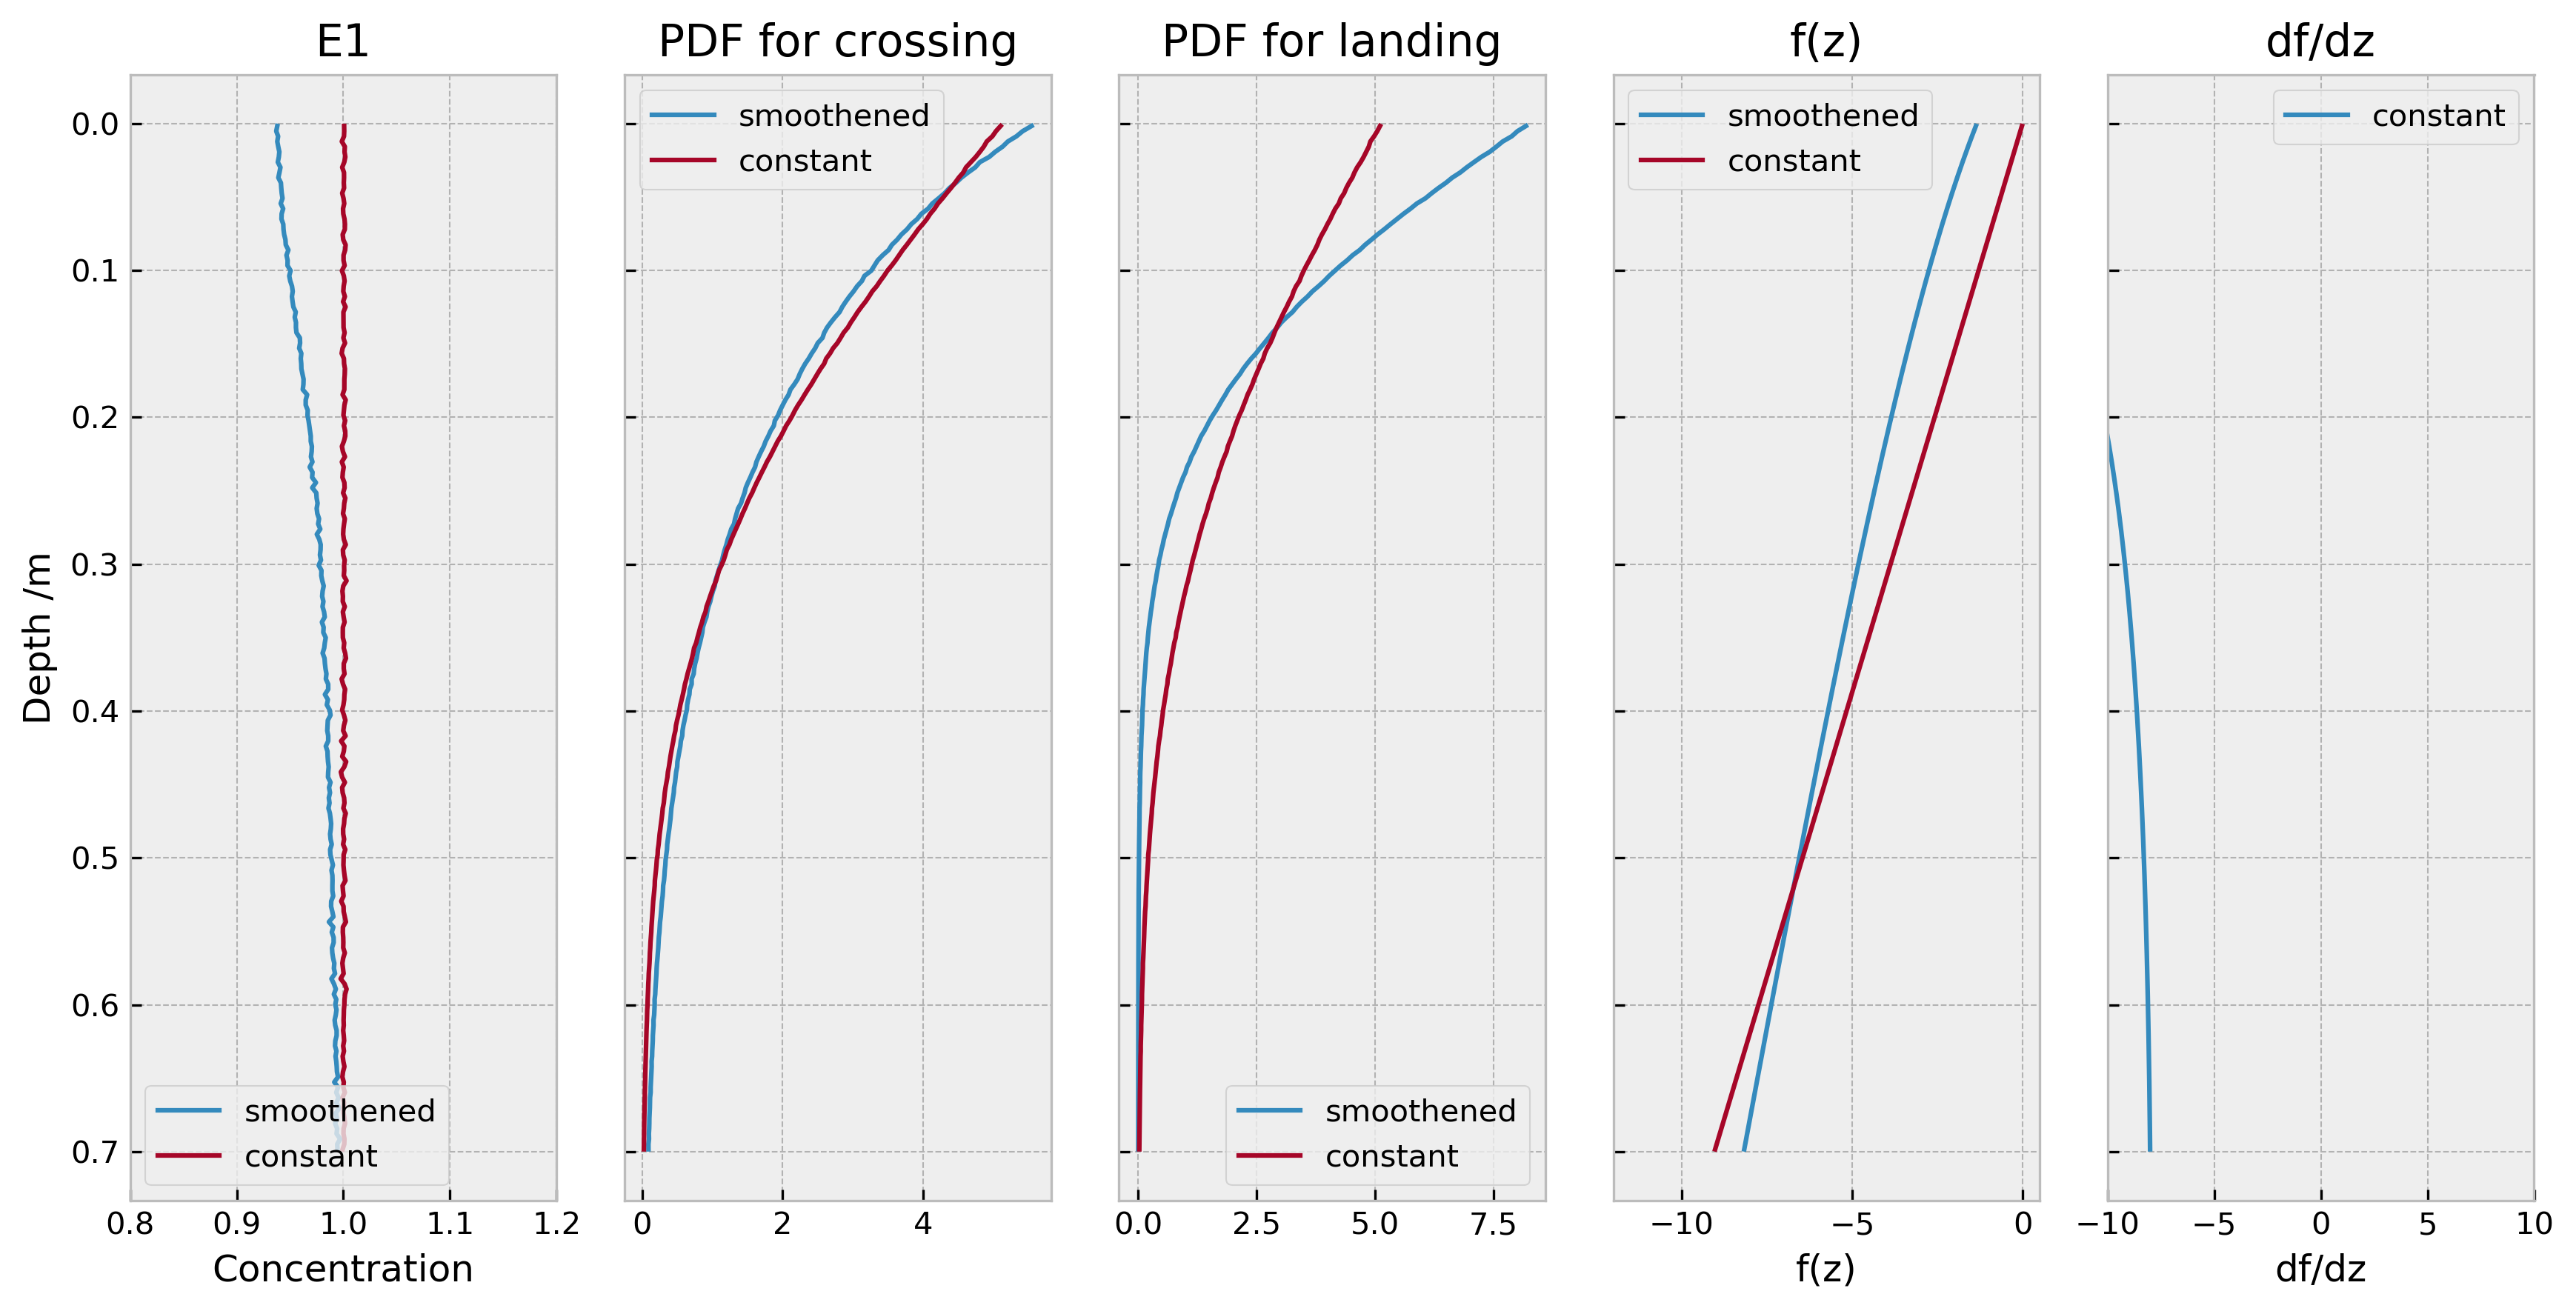

In [6]:
bins = np.linspace(0, Testdepth, Nbins)
midpoints = bins[:-1] + (bins[1]-bins[0]) / 2

fig, ax = plt.subplots(ncols = 5, figsize = (11.69,6), sharey = True, dpi = 300)
ax[0].plot(E1, midpoints, linewidth=1.5, label= "smoothened")
ax[0].plot(E1_Const, midpoints, linewidth=1.5, label= "constant")
ax[0].set_xlabel('Concentration')
ax[0].set_ylabel('Depth /m')
ax[0].set_xlim(0.8, 1.2)
ax[0].set_title('E1')
ax[0].invert_yaxis()
ax[0].legend(loc=3)

ax[1].plot(E1_Cross, midpoints, linewidth=1.5, label= "smoothened")
ax[1].plot(E1_Const_Cross, midpoints, linewidth=1.5, label= "constant")
ax[1].set_xlabel("")
ax[1].set_title("PDF for crossing")
ax[1].legend()

ax[2].plot(E1_Land, midpoints, linewidth=1.5, label= "smoothened")
ax[2].plot(E1_Const_Land, midpoints, linewidth=1.5, label= "constant")
ax[2].set_xlabel("")
ax[2].set_title("PDF for landing")
ax[2].legend()

ax[3].plot(F(midpoints,dt), midpoints, linewidth=1.5, label= "smoothened")
ax[3].plot(F_const(midpoints,dt), midpoints, linewidth=1.5, label= "constant")
ax[3].set_xlabel("f(z)")
ax[3].set_title("f(z)")
ax[3].set_xlim(-12, 0.5)
ax[3].legend()

ax[4].plot(dFdz(midpoints,dt), midpoints, linewidth=1.5, label= "constant")
ax[4].set_xlabel('df/dz')
ax[4].set_title("df/dz")
ax[4].set_xlim(-10, 10)
ax[4].legend()

plt.tight_layout()